In [1]:
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm, t
np.random.seed(42)

In [2]:
def generate_data(n, intercept,
                     slope_left, slope_right, error_term):
    x = np.linspace(-1, 1, 2*n)
    y_left = intercept + slope_left*x[:n] + error_term*np.random.randn(n)
    y_right = intercept + slope_right*x[n:] + error_term*np.random.randn(n)
    y = np.hstack((y_left, y_right))
    return x, y

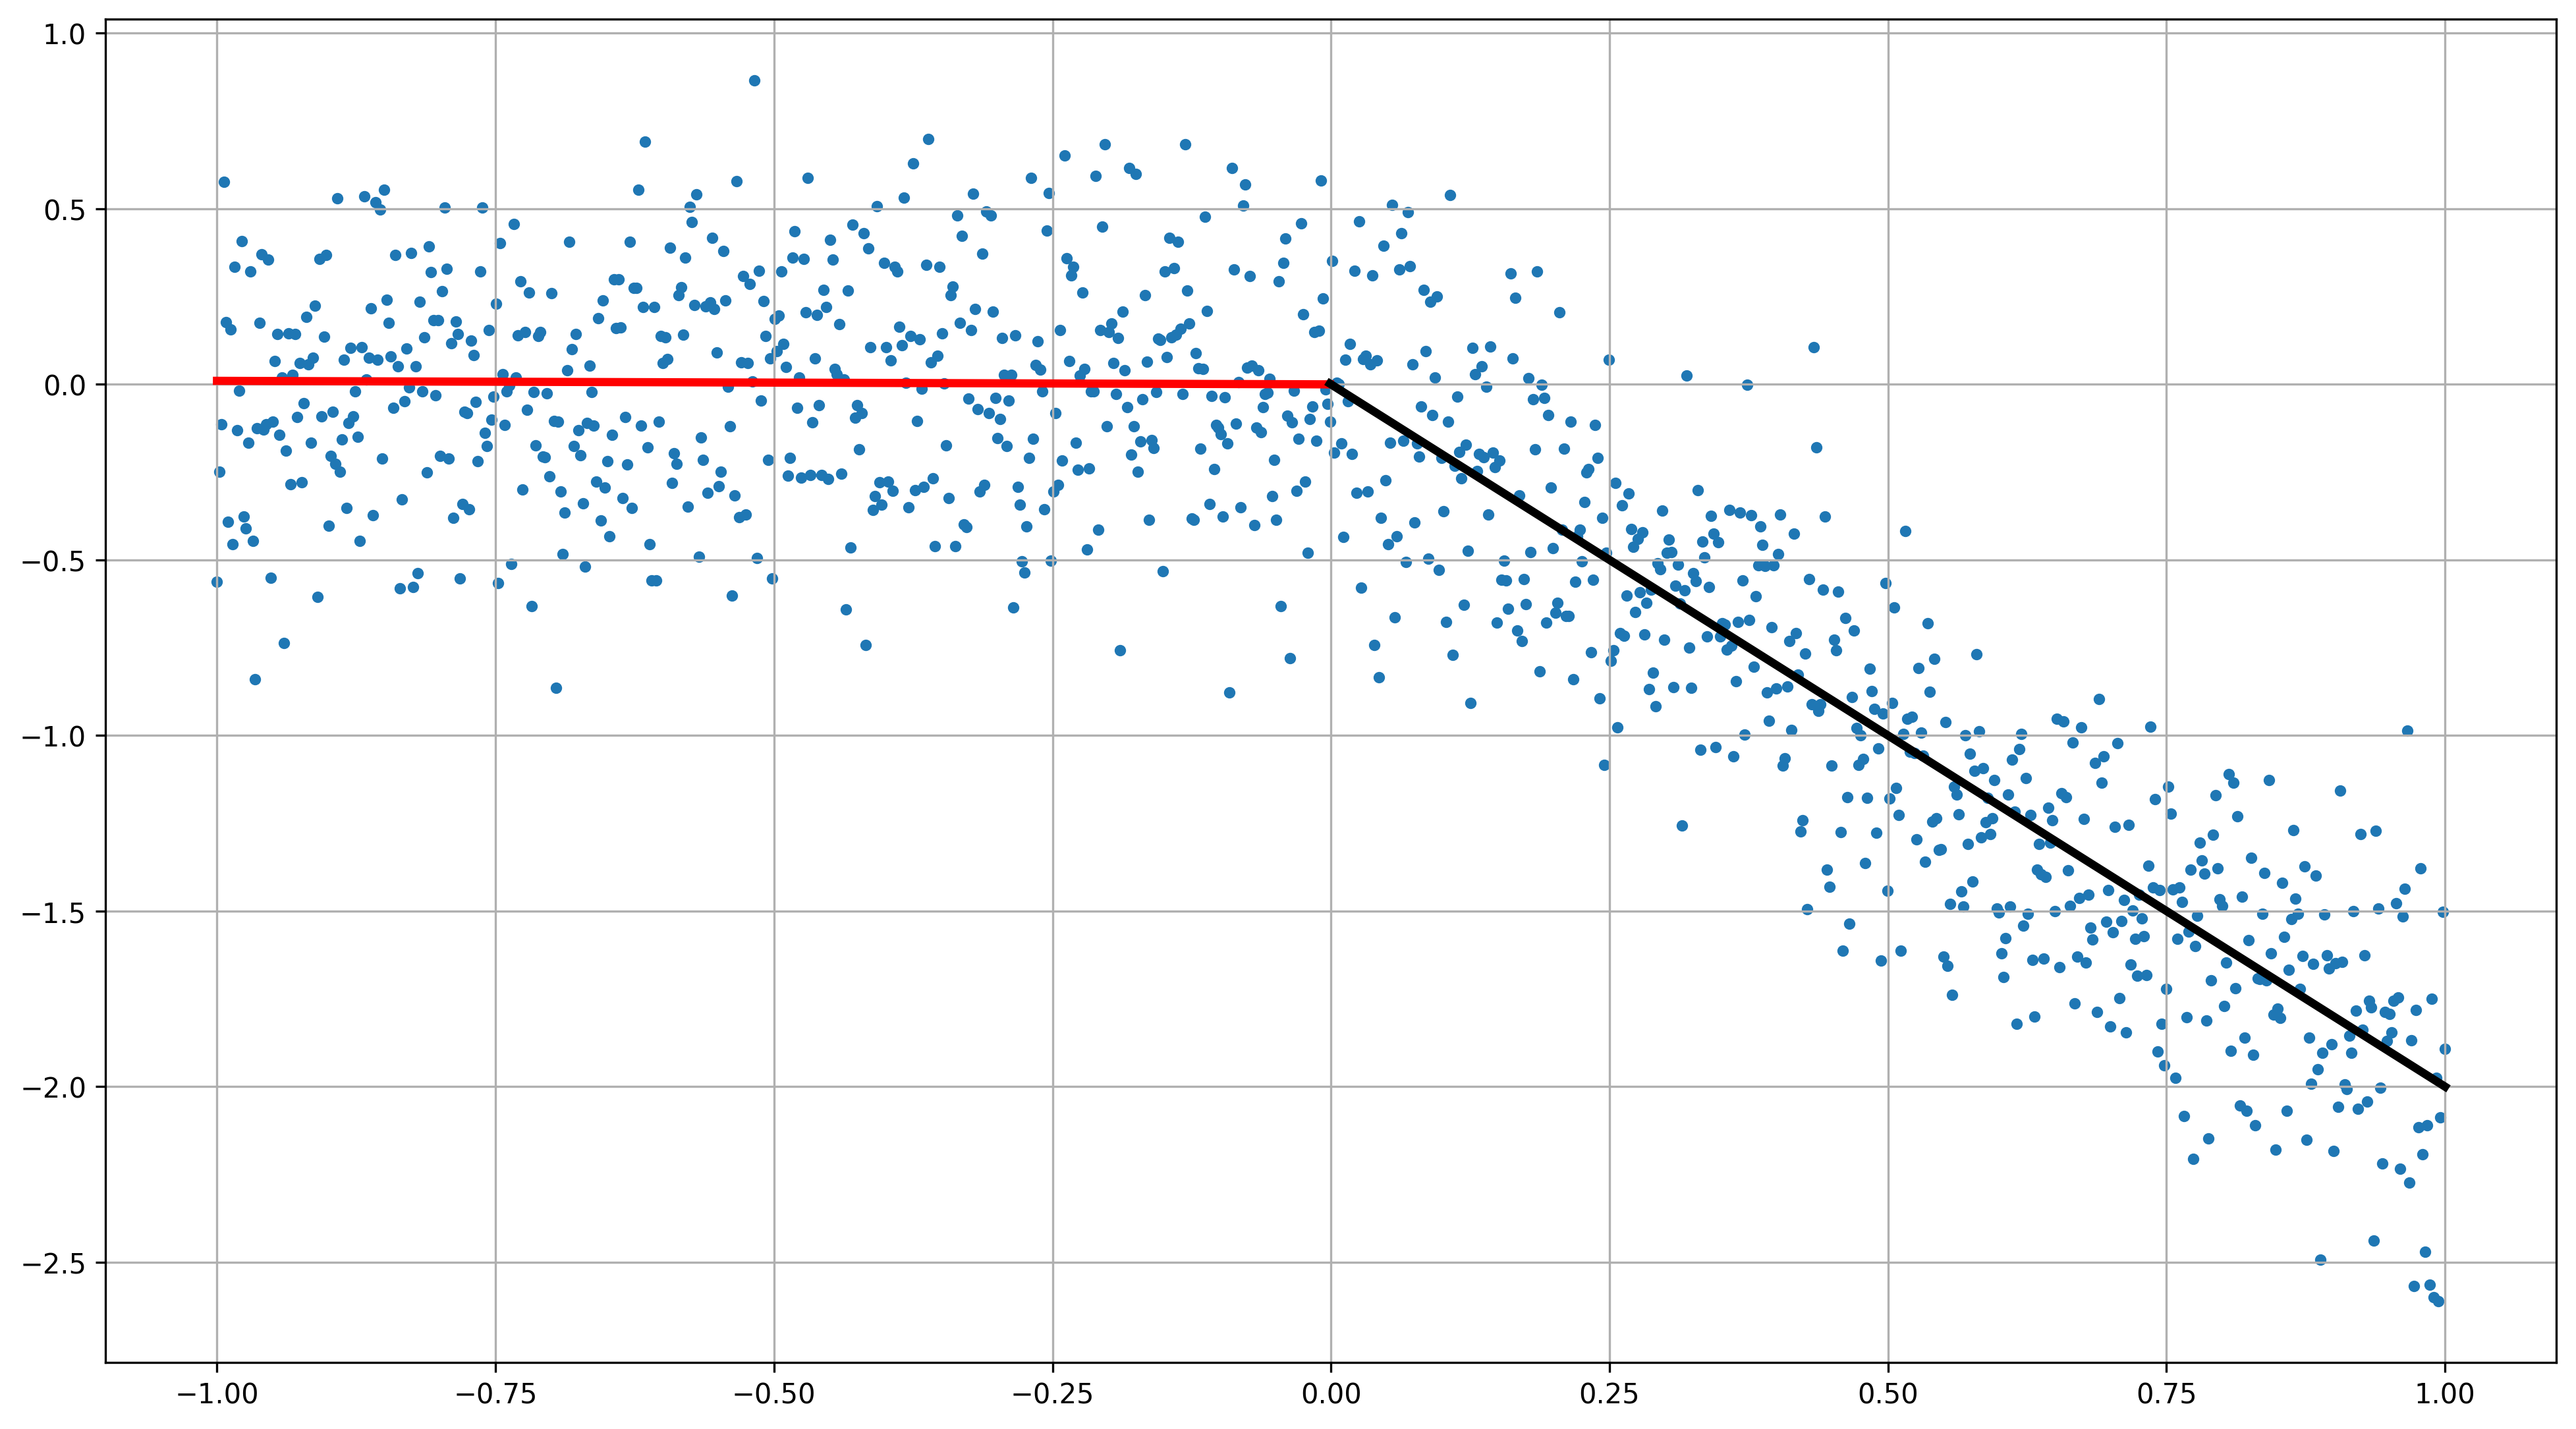

In [6]:
x, y = generate_data(n=500, intercept=0, slope_left=-0.01, slope_right=-2, error_term=0.3)
plt.figure(figsize=(16,9))
plt.scatter(x, y, s=10)
plt.plot([x[0], x[499]], [0 + -0.01*x[0], 0 + -0.01*x[499]], "r", linewidth=3)
plt.plot([x[499], x[-1]], [0 - 2*x[499], 0 - 2*x[-1]], "k", linewidth=3)
plt.grid()
plt.show()

In [4]:
class peak_slope_sign():
    def __init__(self, x, y, epsilon, region, turning=0):
        self.turning = turning
        self.x = x
        self.y = y
        self.epsilon = epsilon
        self.region = region # fitting 範圍
        self.left_Sxx = None
        self.right_Sxx = None
        self.left_dot_num = None
        self.right_dot_num = None

        self.demarcation_index = np.where((self.x > self.turning-self.epsilon) & \
             (self.x < self.turning+self.epsilon))[0] # 真實轉折點附近內所有的點當作候選點
        
        self.intercept_left_list, self.slope_left_list = [], []
        self.intercept_right_list, self.slope_right_list =[], []
    
    def demarcation_slope_product(self): # 所有候選點的兩側斜率乘積
        if not self.slope_left_list:
            for i in self.demarcation_index:
                start_index = np.where(self.x > self.x[i]-self.region)[0][0]
                end_index = np.where(self.x < self.x[i]+self.region)[0][-1]
                coef_left = P.polyfit(x=self.x[start_index:i],
                                      y=self.y[start_index:i],
                                      deg=1)
                coef_right = P.polyfit(x=self.x[i:end_index],
                                       y=self.y[i:end_index],
                                       deg=1)
                self.intercept_left_list.append(coef_left[0])
                self.intercept_right_list.append(coef_right[0])
                self.slope_left_list.append(coef_left[1])
                self.slope_right_list.append(coef_right[1])
        return np.array(self.slope_left_list) * np.array(self.slope_right_list)
    
    def test_coordinate_peak(self, x_coordinate):
        left_start_index = np.min(np.where(self.x > x_coordinate-self.region))
        left_end_index = np.max(np.where(self.x < x_coordinate))
        right_start_index = np.min(np.where(self.x > x_coordinate))
        right_end_index = np.max(np.where(self.x < x_coordinate+self.region))
        X = sm.add_constant(self.x)

        self.left_Sxx = np.sum((self.x[left_start_index:left_end_index+1] - \
             np.mean(self.x[left_start_index:left_end_index+1]))**2)
        self.right_Sxx = np.sum((self.x[right_start_index:right_end_index+1] - \
             np.mean(self.x[right_start_index:right_end_index+1]))**2)
        self.left_dot_num = left_end_index-left_start_index+1
        self.right_dot_num = right_end_index-right_start_index+1

        mod_left = sm.OLS(self.y[left_start_index:left_end_index+1],
                          X[left_start_index:left_end_index+1])
        res_left = mod_left.fit()
        mod_right = sm.OLS(self.y[right_start_index:right_end_index+1],
                           X[right_start_index:right_end_index+1])
        res_right = mod_right.fit()

        left_pvalue = 1 - t.cdf(res_left.tvalues[-1], df=left_end_index-left_start_index+1-2)
        right_pvalue = t.cdf(res_right.tvalues[-1], df=right_end_index-right_start_index+1-2)
        
        return {"beta1_hat":round(res_left.params[1],5),
                "sigma1_hat":round((res_left.mse_resid)**(0.5), 5),
                "Left t-statistic":round(res_left.tvalues[-1],5),
                "Left p-value":round(left_pvalue,5),
                "beta2_hat":round(res_right.params[1],5),
                "sigma2_hat":round((res_right.mse_resid)**(0.5), 5),
                "Right t-statistic":round(res_right.tvalues[-1],5),
                "Right p-value":round(right_pvalue,5)}
    
    def test_coordinate_valley(self, x_coordinate):
        left_start_index = np.min(np.where(self.x > x_coordinate-self.region))
        left_end_index = np.max(np.where(self.x < x_coordinate))
        right_start_index = np.min(np.where(self.x > x_coordinate))
        right_end_index = np.max(np.where(self.x < x_coordinate+self.region))
        X = sm.add_constant(self.x)
        
        self.left_Sxx = np.sum((self.x[left_start_index:left_end_index+1] - \
             np.mean(self.x[left_start_index:left_end_index+1]))**2)
        self.right_Sxx = np.sum((self.x[right_start_index:right_end_index+1] - \
             np.mean(self.x[right_start_index:right_end_index+1]))**2)
        self.left_dot_num = left_end_index-left_start_index+1
        self.right_dot_num = right_end_index-right_start_index+1

        mod_left = sm.OLS(self.y[left_start_index:left_end_index+1],
                          X[left_start_index:left_end_index+1])
        res_left = mod_left.fit()
        mod_right = sm.OLS(self.y[right_start_index:right_end_index+1],
                           X[right_start_index:right_end_index+1])
        res_right = mod_right.fit()

        left_pvalue = t.cdf(res_left.tvalues[-1], df=left_end_index-left_start_index+1-2)
        right_pvalue = 1 - t.cdf(res_right.tvalues[-1], df=right_end_index-right_start_index+1-2)
        
        return {"beta1_hat":round(res_left.params[1],5),
                "sigma1_hat":round(res_left.mse_resid, 5),
                "Left t-statistic":round(res_left.tvalues[-1],5),
                "Left p-value":round(left_pvalue,5),
                "beta2_hat":round(res_right.params[1],5),
                "Right t-statistic":round(res_right.tvalues[-1],5),
                "sigma2_hat":round(res_right.mse_resid, 5),
                "Right p-value":round(right_pvalue,5)}
        
    def scatter_reg_plot(self, x_coordinate):
        left_start_index = np.min(np.where(self.x > x_coordinate-self.region))
        left_end_index = np.max(np.where(self.x < x_coordinate))
        right_start_index = np.min(np.where(self.x > x_coordinate))
        right_end_index = np.max(np.where(self.x < x_coordinate+self.region))
        X = sm.add_constant(self.x)

        mod_left = sm.OLS(self.y[left_start_index:left_end_index+1],
                          X[left_start_index:left_end_index+1])
        res_left = mod_left.fit()
        mod_right = sm.OLS(self.y[right_start_index:right_end_index+1],
                           X[right_start_index:right_end_index+1])
        res_right = mod_right.fit()

        plt.figure(figsize=(16, 9))
        plt.scatter(self.x, self.y, c="y", s=15)

        plt.plot(self.x[left_start_index:left_end_index+1],
                 res_left.predict(),
                 "r")
        
        plt.plot(self.x[right_start_index:right_end_index+1],
                 res_right.predict(),
                 "k")
        plt.grid()
        plt.show()

In [5]:
test1 = peak_slope_sign(x=x, y=y, epsilon=0.2, region=0.3)
test1.test_coordinate_peak(0)

{'beta1_hat': -0.38779,
 'sigma1_hat': 0.31154,
 'Left t-statistic': -1.32157,
 'Left p-value': 0.90583,
 'beta2_hat': -1.76535,
 'sigma2_hat': 0.29781,
 'Right t-statistic': -6.29355,
 'Right p-value': 0.0}

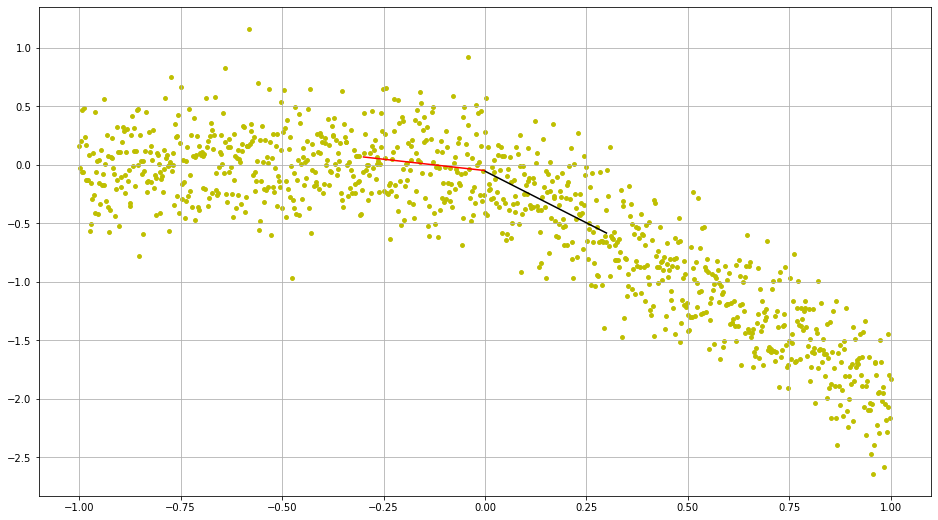

In [6]:
test1.scatter_reg_plot(x_coordinate=0)

In [7]:
def simu_peak_pro(beta_left, beta_right, region, error_term):
    left_betahat_list = []
    right_betahat_list = []
    leftsigma_hat_list = []
    rightsigma_hat_list = []
    left_Sxx = []
    right_Sxx = []

    for i in range(1000):
        np.random.seed(i)
        x, y = generate_data(n=500, intercept=0,
                             slope_left=beta_left, slope_right=beta_right, error_term=error_term) # 生成的標準差為給定的
        test = peak_slope_sign(x=x, y=y, epsilon=0.2, region=region)
        left_betahat_list.append(test.test_coordinate_peak(0)["beta1_hat"])
        right_betahat_list.append(test.test_coordinate_peak(0)["beta2_hat"])
        leftsigma_hat_list.append(test.test_coordinate_peak(0)["sigma1_hat"])
        rightsigma_hat_list.append(test.test_coordinate_peak(0)["sigma2_hat"])
        left_Sxx.append(test.left_Sxx)
        right_Sxx.append(test.right_Sxx)
    
    left_betahat_list = np.array(left_betahat_list)
    right_betahat_list = np.array(right_betahat_list)
    leftsigma_hat_list = np.array(leftsigma_hat_list)
    rightsigma_hat_list = np.array(rightsigma_hat_list)
    left_Sxx = np.array(left_Sxx)
    right_Sxx = np.array(right_Sxx)
    
    # x, y = generate_data(n=500, intercept=0,
    #                      slope_left=beta_left, slope_right=beta_right, error_term=error_term) # 生成的標準差為給定的
    # temp_test = peak_slope_sign(x=x, y=y, epsilon=0.2, region=region)
    # temp_test.test_coordinate_peak(0)

    z_left = -t.ppf(0.05, df=test.left_dot_num-2) - beta_left / (np.mean(leftsigma_hat_list)/np.sqrt(test.left_Sxx))
    z_right = t.ppf(0.05, df=test.right_dot_num-2) - beta_right / (np.mean(rightsigma_hat_list)/np.sqrt(test.right_Sxx))

    # re_left_Z = (left_betahat_list - beta_left) / (leftsigma_hat_list/np.sqrt(left_Sxx))
    # re_right_Z = (right_betahat_list - beta_right) / (rightsigma_hat_list/np.sqrt(right_Sxx))

    nonre_left_Z = left_betahat_list - (-t.ppf(0.05, df=test.left_dot_num-2))*(leftsigma_hat_list/np.sqrt(left_Sxx))
    nonre_right_Z = right_betahat_list + (-t.ppf(0.05, df=test.right_dot_num-2))*(rightsigma_hat_list/np.sqrt(right_Sxx))
    # nonre_left_Z = left_betahat_list - (-t.ppf(0.05, df=temp_test.left_dot_num-2))*(np.mean(leftsigma_hat_list)/np.sqrt(temp_test.left_Sxx))
    # nonre_right_Z = right_betahat_list + (-t.ppf(0.05, df=temp_test.right_dot_num-2))*(np.mean(rightsigma_hat_list)/np.sqrt(temp_test.right_Sxx))
    
    return {"z_left":z_left, "z_right":z_right,
            # "regularized left Z":re_left_Z, "regularized right Z":re_right_Z,
            "non regularized left Z":nonre_left_Z, "non regularized right Z":nonre_right_Z,
            "left index":np.where(nonre_left_Z > 0)[0], "right index":np.where(nonre_right_Z < 0)[0],
            "beta1_hat array":left_betahat_list, "beta2_hat array":right_betahat_list,
            "left sigma_hat array":leftsigma_hat_list, "right sigma_hat array":rightsigma_hat_list,
            "peak slope sign":test}

# 第一次模擬

beta_right={-1, -2, -3}；region={0.1, 0.2, 0.3}

(1)

In [8]:
simu1 = simu_peak_pro(beta_left=-0.01, beta_right=-3, region=0.1, error_term=0.3)
print(f"P(Z>{simu1['z_left']}) = {1-norm.cdf(simu1['z_left'])}", ";", f"P(Z<{simu1['z_right']}) = {norm.cdf(simu1['z_right'])}")
print(simu1["non regularized left Z"][simu1["left index"]].shape[0]/1000, simu1["non regularized right Z"][simu1["right index"]].shape[0]/1000)
print("Sxx:", simu1["peak slope sign"].left_Sxx)

P(Z>1.6840651605095391) = 0.04608453825732439 ; P(Z<0.36985100925725) = 0.6442532470199793
0.046 0.618
Sxx: 0.041733425116808505


In [9]:
np.intersect1d(simu1["left index"], simu1["right index"]).shape

(27,)

In [10]:
print("Min:", np.min(simu1["left sigma_hat array"]), "Max:", np.max(simu1["left sigma_hat array"]),
      "Mean:", np.mean(simu1["left sigma_hat array"]), "Median:", np.median(simu1["left sigma_hat array"]))

Min: 0.20557 Max: 0.41016 Mean: 0.29862395 Median: 0.299075


In [11]:
print("Min:", np.min(simu1["beta1_hat array"]), "Max:", np.max(simu1["beta1_hat array"]),
      "Mean", np.mean(simu1["beta1_hat array"]), "Median:", np.median(simu1["beta1_hat array"]))

Min: -4.77621 Max: 4.69176 Mean -0.06403233000000001 Median: -0.06473499999999999


# 第二次模擬

In [12]:
simu2 = simu_peak_pro(beta_left=2, beta_right=-1.5, region=0.2, error_term=0.3)
print(f"P(Z>{simu2['z_left']}) = {1-norm.cdf(simu2['z_left'])}", ";", f"P(Z<{simu2['z_right']}) = {norm.cdf(simu2['z_right'])}")
print(simu2["non regularized left Z"][simu2["left index"]].shape[0]/1000, simu2["non regularized right Z"][simu2["right index"]].shape[0]/1000)
print("Sxx:", simu2["peak slope sign"].left_Sxx)

P(Z>-2.188975729908325) = 0.9857006979593755 ; P(Z<1.2249541493900884) = 0.8897037517948608
0.987 0.908
Sxx: 0.33396760123486846


In [13]:
np.intersect1d(simu2["left index"], simu2["right index"]).shape

(896,)

In [14]:
print("Min:", np.min(simu2["left sigma_hat array"]), "Max:", np.max(simu2["left sigma_hat array"]),
      "Mean:", np.mean(simu2["left sigma_hat array"]), "Median:", np.median(simu2["left sigma_hat array"]))

Min: 0.24546 Max: 0.37032 Mean: 0.30024432 Median: 0.30115499999999995


In [15]:
print("Min:", np.min(simu2["beta1_hat array"]), "Max:", np.max(simu2["beta1_hat array"]),
      "Mean", np.mean(simu2["beta1_hat array"]), "Median:", np.median(simu2["beta1_hat array"]))

Min: 0.2741 Max: 3.55606 Mean 1.9975411200000002 Median: 1.97749


# 第三次模擬

In [16]:
simu3 = simu_peak_pro(beta_left=1, beta_right=1, region=0.2, error_term=0.1)
print(f"P(Z>{simu3['z_left']}) = {1-norm.cdf(simu3['z_left'])}", ";", f"P(Z<{simu3['z_right']}) = {norm.cdf(simu3['z_right'])}")
print(simu3["non regularized left Z"][simu3["left index"]].shape[0]/1000, simu3["non regularized right Z"][simu3["right index"]].shape[0]/1000)
print("Sxx:", simu3["peak slope sign"].left_Sxx)

P(Z>-4.113746126902815) = 0.9999805355222473 ; P(Z<-7.431560028899825) = 5.3662137556677875e-14
1.0 0.0
Sxx: 0.33396760123486846


In [17]:
np.intersect1d(simu3["left index"], simu3["right index"]).shape

(0,)

# 全部資料模擬

In [18]:
simu4 = simu_peak_pro(beta_left=-0.01, beta_right=-1, region=1, error_term=0.3)
print(f"P(Z>{simu4['z_left']}) = {1-norm.cdf(simu4['z_left'])}", ";", f"P(Z<{simu4['z_right']}) = {norm.cdf(simu4['z_right'])}")
print(simu4["non regularized left Z"][simu4["left index"]].shape[0]/1000, simu4["non regularized right Z"][simu4["right index"]].shape[0]/1000)
print("Sxx:", simu4["peak slope sign"].left_Sxx)

P(Z>1.8628140786648661) = 0.03124421428490798 ; P(Z<19.845603800605836) = 1.0
0.02 1.0
Sxx: 41.499958416875344


In [19]:
np.intersect1d(simu4["left index"], simu4["right index"])

array([ 12,  44,  84, 198, 202, 205, 223, 231, 281, 409, 452, 684, 756,
       800, 810, 867, 912, 941, 974, 988], dtype=int64)

In [20]:
simu4["beta1_hat array"][np.intersect1d(simu4["left index"], simu4["right index"])]

array([0.07823, 0.07927, 0.13347, 0.08974, 0.09017, 0.07514, 0.08965,
       0.10456, 0.1186 , 0.09563, 0.08779, 0.08141, 0.11999, 0.08436,
       0.0855 , 0.07645, 0.1102 , 0.08053, 0.10355, 0.10546])

# Power模擬1

In [51]:
simu5 = simu_peak_pro(beta_left=0.1, beta_right=-0.1, region=0.2, error_term=0.3)
print(f"P(Z>{simu5['z_left']}) = {1-norm.cdf(simu5['z_left'])}", ";", f"P(Z<{simu5['z_right']}) = {norm.cdf(simu5['z_right'])}")
print(simu5["non regularized left Z"][simu5["left index"]].shape[0]/1000, simu5["non regularized right Z"][simu5["right index"]].shape[0]/1000)
print("Sxx:", simu5["peak slope sign"].left_Sxx)

P(Z>1.4680748696964383) = 0.07104194347173631 ; P(Z<-1.4681841926151145) = 0.07102709843821332
0.068 0.079
Sxx: 0.33396760123486846


In [52]:
np.intersect1d(simu5["left index"], simu5["right index"]).shape

(6,)